In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchview import draw_graph
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)

train_set = MNIST("../mnist/", train=True, transform=tensor_transforms, download = True)
test_set = MNIST("../mnist/", train=False, transform=tensor_transforms, download = True)

### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"


In [17]:
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=8, latent_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(codebook_size, latent_dim)# [C,L]
        self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
    
    def forward (self, x):
        # x: [B,L]
        # embed : [C,L]
        C = self.codebook_size
        batch_size = x.shape[0] # B
        L2 = torch.sum(x**2, dim = -1).unsqueeze(0) # [B, 1]
        LC = self.embedding.weight @ x.t()
        C2 = torch.sum(self.embedding.weight**2, dim = -1).unsqueeze(1)
        distances = L2 + C2 - 2*LC # [B,C]
        closest = torch.argmin(distances, dim = 0)

        quantized_latents_idx = torch.nn.functional.one_hot(closest, num_classes=C).float() 
        quantized_latents = quantized_latents_idx @ self.embedding.weight
        return quantized_latents, closest


vq = VectorQuantizer(codebook_size=8,latent_dim=2)
rand = torch.randn(4,2)
vq(rand)


(tensor([[ 0.1086,  0.0423],
         [ 0.0791,  0.0756],
         [ 0.0756, -0.0995],
         [-0.0251, -0.0119]], grad_fn=<MmBackward0>),
 tensor([6, 3, 4, 0]))

# rvq 

In [31]:
class LinearResidualVectorQuantizedVAE(nn.Module):
    def __init__(self, latent_dim=2, codebook_size=64, num_codebooks=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
        nn.Linear(32*32, 128),
        nn.ReLU(),
        nn.Linear(128, 64), 
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, latent_dim)
    )
        self.rvq = nn.ModuleList([VectorQuantizer(codebook_size=codebook_size, latent_dim=latent_dim) for _ in range(num_codebooks)])
        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 32*32),
                nn.Sigmoid()
    )
    def quantize(self,z, return_code_idx_only = False):
        codebook_loss = 0
        commitment_loss = 0
        quantized_codes = []
        code_indexes = []
        final_quantized = torch.zeros_like(z)

        for quantizer in self.rvq:
            quantized, code_idx = quantizer(z)
            code_indexes.append(code_idx)

            codebook_loss += torch.mean((quantized - z.detach())**2)
            commitment_loss += 0.25 *torch.mean((quantized.detach() - z)**2)
            codes = z + (quantized - z).detach()
            final_quantized += codes
            quantized_codes.append(codes)

            z = z - codes.detach() 

        if return_code_idx_only:
            return torch.stack(code_indexes, dim = -1)
        else:
            return final_quantized, codebook_loss, commitment_loss
    
    @torch.no_grad()
    def get_codes(self, codes_idx):
        x= x.flatten(start_dim=1) # [B,32*32]
        z = self.encoder(x)
        quantized_latents_idx = self.quantize(z, return_code_idx_only = True)
        return quantized_latents_idx
    
    @torch.no_grad()
    def decode_codes(self, codes_idx):
        batch_size = codes_idx.shape[0]
        rvq_codes = torch.zeros(batch_size, self.latent_dim)
        for idx, quantizer in enumerate(self.rvq):
            q_codes = codes_idx[:,idx]
            quantized_embedding = quantizer.embedding[q_codes]
            rvq_codes += quantized_embedding

        decoded = self.decoder(rvq_codes)
        decoded = decoded.reshape(batch_size, 1, 32, 32)
        return decoded

    def forward_enc(self,x):
        z = self.encoder(x)
        return z
    

    def forward_dec(self,x):
        # x: [B,latent_dim]
        final_quantized, codebook_loss, commitment_loss = self.quantize(x)
        decoded = self.decoder(final_quantized)
        return final_quantized, decoded, codebook_loss, commitment_loss

    def forward(self, x):
        # encoder
        batch_size, channels, height, width = x.shape
        x= x.flatten(start_dim=1) # [B,32*32]
        latents = self.forward_enc(x) # [B,latent_dim]
        final_quantized, decoded, codebook_loss, commitment_loss  = self.forward_dec(latents) # [B,32*32]

        decoded = decoded.reshape(batch_size, channels, height, width)

        return latents, final_quantized, decoded, codebook_loss, commitment_loss


In [ ]:
# Linear Vector Quantized VAE
class LinearVectorQuantizedVAE(nn.Module):
    def __init__(self, latent_dim=2, codebook_size=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )

        self.vq = VectorQuantizer(codebook_size, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid()
        )


    def forward_enc (self, x):
        z = self.encoder(x)
        return z
    

    def quantize(self, z):
        codes, quantized_latents_idx = self.vq(z)
        # codebook loss: 
        codebook_loss = torch.mean((codes - z.detach())**2)
        # commitment loss:
        commitment_loss = torch.mean((codes.detach() - z)**2)

        codes = z + (codes - z).detach()
        return codes, codebook_loss, commitment_loss


    def forward_dec(self, x):
        codes, codebook_loss, commitment_loss = self.quantize(x)
        decoded  = self.decoder(codes)
        return codes, decoded, codebook_loss, commitment_loss
    
    def forward(self, x):
        batch, channels, height, width = x.shape
        x = x.flatten(start_dim=1)
        z = self.forward_enc(x)
        quantized_latents, decoded, codebook_loss, commitment_loss = self.forward_dec(z)
        decoded = decoded.reshape(batch, channels, height, width)

        return z, quantized_latents, decoded, codebook_loss, commitment_loss

In [5]:
data_variance = torch.var(train_set.data/255.)

def train(model,
          kl_weight,
          train_set,
          test_set,
          batch_size, 
          training_iterations, 
          evaluation_iterations,
          model_type="VQVAE"):

    if model_type != "VAE": kl_weight = None
        
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    
    encoded_data_per_eval = []
    quantized_encoded_data_per_eval = [] if model_type == "VQVAE" else None
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))
    
    train = True
    
    step_counter = 0
    while train:

        for images, labels in trainloader:
            
            images = images.to(device)

            if model_type == "VQVAE":
                encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
                reconstruction_loss = torch.mean((images-decoded)**2) / data_variance
                loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
                
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:
                
                model.eval()
                
                encoded_evaluations = []
                if model_type == "VQVAE":
                    quantized_encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)
            
                    if model_type == "VQVAE":
                        encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
                        reconstruction_loss = torch.mean((images-decoded)**2) / data_variance
                        loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
                    
                        
                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu(), labels.reshape(-1,1)
                    
                    encoded_evaluations.append(torch.cat((encoded.flatten(1), labels), axis=-1))

                    if model_type == "VQVAE":
                        quantized_encoded = quantized_encoded.cpu()
                        quantized_encoded_evaluations.append(torch.cat((quantized_encoded.flatten(1), labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())
                if model_type == "VQVAE":
                    quantized_encoded_data_per_eval.append(torch.concatenate(quantized_encoded_evaluations).detach())
                
                                                       
                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)
                
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)
           
            
            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    if model_type == "VQVAE":
        quantized_encoded_data_per_eval = [np.array(i) for i in quantized_encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])
    
    return model, train_losses, evaluation_losses, encoded_data_per_eval, quantized_encoded_data_per_eval

In [15]:
linear_vqvae = LinearVectorQuantizedVAE()
(linear_vqvae, train_losses, 
 evaluation_losses, linear_vqvae_encoded_data_per_eval, 
 linear_vqvae_quantized_encoded_data_per_eval) = train(linear_vqvae,
                                                       kl_weight=None,
                                                       train_set=train_set,
                                                       test_set=test_set,
                                                       batch_size=64,
                                                       training_iterations=25000,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.5351343401670456
Final Evaluation Loss 0.5373231504753138


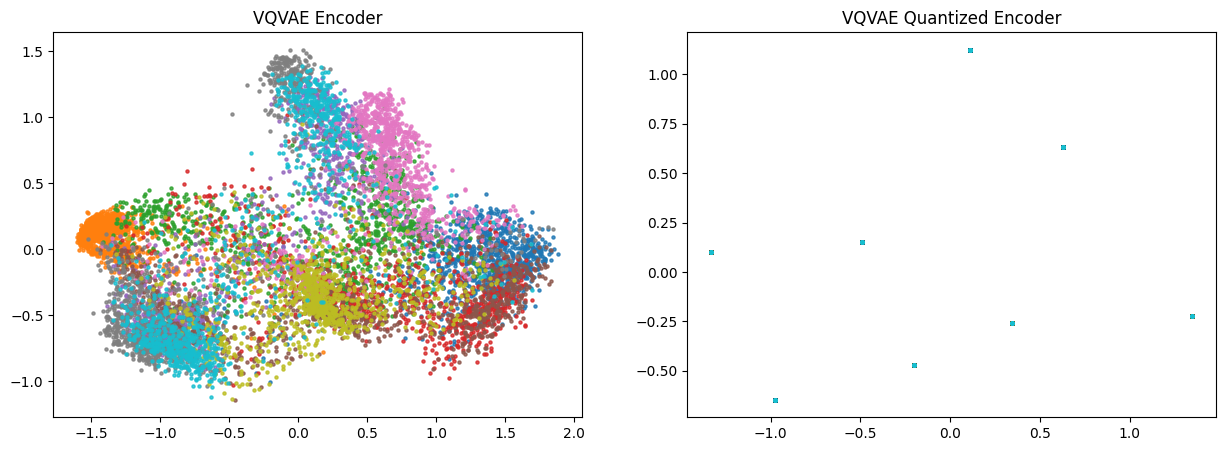

In [16]:
encoded_latent = linear_vqvae_encoded_data_per_eval[-1]
quantized_encoded_latent = linear_vqvae_quantized_encoded_data_per_eval[-1] 

fig, ax = plt.subplots(1,2, figsize=(15,5))

### Plot Continuous Encoded ###
encoded_latent = pd.DataFrame(encoded_latent, columns=["x", "y", "class"])
encoded_latent = encoded_latent.sort_values(by="class")
encoded_latent["class"] = encoded_latent["class"].astype(int).astype(str)
for grouper, group in encoded_latent.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[0].set_title("VQVAE Encoder")

### Plot Quantized ###
quantized_encoded_latent = pd.DataFrame(quantized_encoded_latent, columns=["x", "y", "class"])
quantized_encoded_latent = quantized_encoded_latent.sort_values(by="class")
quantized_encoded_latent["class"] = quantized_encoded_latent["class"].astype(int).astype(str)
for grouper, group in quantized_encoded_latent.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[1].set_title("VQVAE Quantized Encoder")
plt.show()

In [30]:
linear_vqvae = LinearResidualVectorQuantizedVAE()
(linear_vqvae, train_losses, 
 evaluation_losses, linear_vqvae_encoded_data_per_eval, 
 linear_vqvae_quantized_encoded_data_per_eval) = train(linear_vqvae,
                                                       kl_weight=None,
                                                       train_set=train_set,
                                                       test_set=test_set,
                                                       batch_size=64,
                                                       training_iterations=25000,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.3291728811264038
Final Evaluation Loss 0.32900918687984443
